## Evaluate a model from the FEDn model trail 

In [1]:
import os
import tensorflow as tf
from stackn import stackn
from fedn.utils.kerashelper import KerasHelper
import tensorflow
from client.models.AMLmodel import construct_model
import sys
# Before using tensorflow:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tensorflow.keras.backend as KB
from matplotlib import pylab as plt
import tensorflow.keras

import pickle
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.3.2
Keras Version: 2.4.0

Python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
GPU is NOT AVAILABLE


## Load a given FEDn model version as a native Keras model 

In [2]:
# This asssumes that we are storing the model trail in Studio Minio, 
# and that we have mounted the minio-vol volume when staring the lab session. 
model_id = '044e6d5c-f187-4805-af04-127f11f01460'
fedn_model = '/home/jovyan/work/minio-vol/fedn-models/{}'.format(model_id)
helper = KerasHelper()
weights = helper.load_model(fedn_model)
model = construct_model()
model.set_weights(weights)

In [3]:
import numpy as np
from client.data.datagenerator import DataGenerator
labels1 = np.load('dataset/processed/data_partitions/partition1/labels.npy', allow_pickle=True).item()
data_path1 = 'dataset/processed/data_partitions/partition1/data_singlets'

ids1 = [l for l in labels1]
np.random.shuffle(ids1)

test_gen = DataGenerator(ids1,labels1, data_path1, dim=(100,100), batch_size=32)
labels, preds = test_gen.predict_all(model)
np.sort([k for k in labels1])

array(['BAS_0001', 'BAS_0028', 'BAS_0030', 'BAS_0031', 'BAS_0044',
       'BAS_0052', 'EBO_0008', 'EOS_0018', 'EOS_0051', 'EOS_0069',
       'EOS_0100', 'EOS_0138', 'EOS_0162', 'EOS_0182', 'EOS_0198',
       'EOS_0236', 'EOS_0247', 'EOS_0259', 'EOS_0276', 'EOS_0283',
       'EOS_0308', 'EOS_0334', 'EOS_0346', 'EOS_0355', 'EOS_0375',
       'EOS_0421', 'LYA_0009', 'LYT_0007', 'LYT_0008', 'LYT_0015',
       'LYT_0060', 'LYT_0082', 'LYT_0180', 'LYT_0182', 'LYT_0240',
       'LYT_0295', 'LYT_0308', 'LYT_0351', 'LYT_0380', 'LYT_0450',
       'LYT_0518', 'LYT_0572', 'LYT_0615', 'LYT_0656', 'LYT_0675',
       'LYT_0687', 'LYT_0692', 'LYT_0746', 'LYT_0753', 'LYT_0755',
       'LYT_0767', 'LYT_0815', 'LYT_0831', 'LYT_0945', 'LYT_0955',
       'LYT_0966', 'LYT_1008', 'LYT_1074', 'LYT_1093', 'LYT_1274',
       'LYT_1477', 'LYT_1513', 'LYT_1524', 'LYT_1549', 'LYT_1573',
       'LYT_1587', 'LYT_1590', 'LYT_1629', 'LYT_1637', 'LYT_1674',
       'LYT_1678', 'LYT_1683', 'LYT_1694', 'LYT_1721', 'LYT_17

In [4]:
def confusion_matrix(model, data_gen):
    
    labels, preds = data_gen.predict_all(model)

    y_pred = np.argmax(preds,1)
    y_data = np.argmax(labels,1)
    M = np.zeros((16,16))

    for pred_, true_ in zip(y_pred,y_data):
        M[true_,pred_] +=1
    
    M[15,:15] = np.sum(M[:15,:15],0)
    M[:15,15] = np.sum(M[:15,:15],1)
    M[15,15] = np.sum(M[:15,:15])
        
    return M

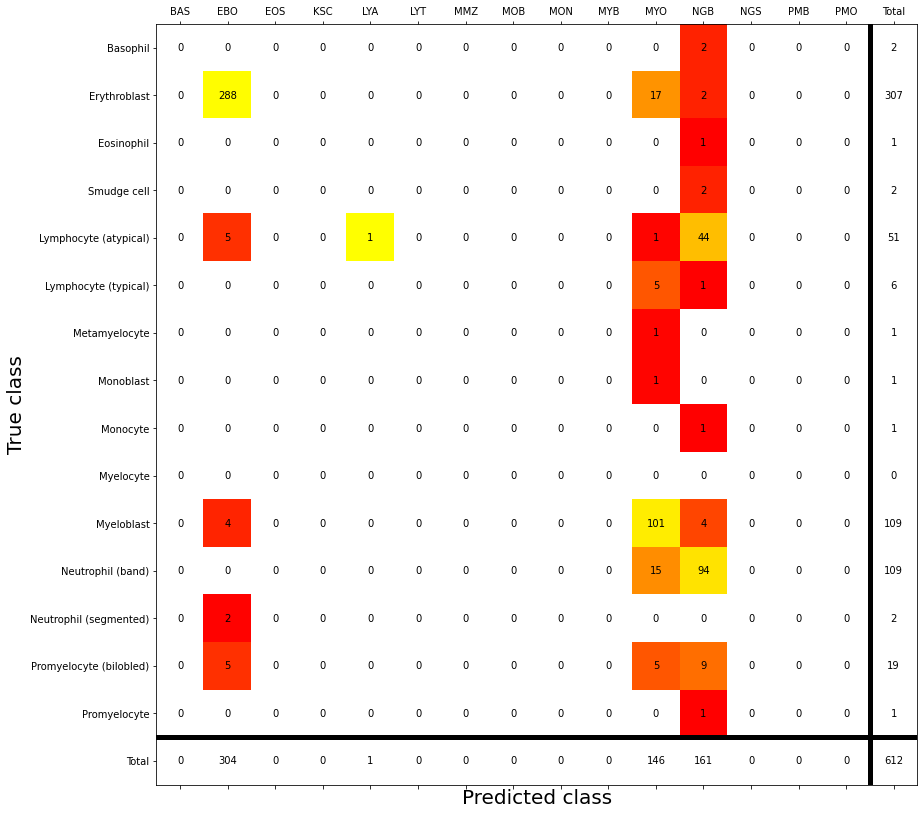

In [5]:
import matplotlib
from client.models.AMLmodel import classes as aml_classes

class_names_y = [aml_classes[k] for k in aml_classes] + ['Total']
class_names_x = [k for k in aml_classes] + ['Total']


def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.autumn):
    
    f, ax = plt.subplots(1,1,figsize=(20,14))
    color_mat = np.zeros(matrix.shape)
    color_mat[:15,:15] = matrix[:15,:15]/np.maximum(1,np.sum(matrix[:15,:15],0))
    ax.matshow(color_mat, cmap=cmap, norm=matplotlib.colors.LogNorm()) 

    tick_mark = np.arange(16)
    ax.set_xticks(tick_mark)
    ax.set_yticks(tick_mark)

    ax.set_xticklabels(class_names_x)
    ax.set_yticklabels(class_names_y)
    
    for (i, j), z in np.ndenumerate(matrix):
        
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

    ax.axvline(x=14.5,color='black',lw=5)
    ax.axhline(y=14.5,color='black', lw=5)
    ax.set_xlabel('Predicted class', fontsize=20)
    ax.set_ylabel('True class', fontsize=20)

M = confusion_matrix(model, test_gen)
plot_confusion_matrix(M)
plt.savefig('confusion_sample.png')